# <p style="text-align: center;">AT-TPC Report

 ### <p style="text-align: right;">Authors:
<p style="text-align: right;">Ceulemans Andreas, Fracassetti Stefano, Youssef Ahmed
    

![Active Target](img/AT_drawing.png)

In [1]:
# Common import

import os

import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score, classification_report)

from functools import reduce # for union of more than 2 arrays

from helper_functions import *


#Fixing seed for reproducibility
np.random.seed(42)

C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# <span style="color:darkred">Description of the Project</span> 


### Task
The main objective is to classify events aquired from an Active Target (simulated data), as being "beam" or "reaction" events. The idea is to implement a "software trigger" which would be able to effectively select only relevant data to save on disk for future analysis.

### Data Format
Data are saved in the file "Mg22_alphaalpha_digiSim.h5", which contains 2000 simulated events: even numbers are "reaction" events, while odd numbers are "beam" event.<br>
Each event is constitued by a point cloud of the active pads for that event.<br>
In turn, every hit pad is associated with a 4-tuple (x,y,z,q): x and y are the position of the hit pad on the detector plane, z is the coordinare associated to the beam axis, and q is the charge deposited on the pad.<br> 
Actually, there is an extra column associated with time (not needed since data already contains the z coordinate thanks to a pre-processing phase), and also an extra column of zeros, unnecessary for this analysis.<br>
The number of hit pads may vary for each event, ranging from around 20, up to a few hundred.

### Strategy
We will apply the ML techiques learned during the Talent Course, in order to analyse the data and reach the best performance possible.<br>
First there will be a section dedicated to data visualization, and in which we will discuss the general characteristic of the task. Afterwards, we will propose various approaches to tackle to problem, and show the results for each methods. Eventually, we will summarize and discuss the outcomes in the final section.

Models used in this project:
- Logistic Regression
- Random Forest
- Dense Neural Networks DNN
- K-Means

# <span style="color:darkred">Data Exploration</span> 

### Let's have a look to the data file 

#### <p style="text-align: center;"> HDF5 file Format
First we load the data, which are stored as a hdf5 file, a (Hierarchical Data File) format designed to store and organize large amounts of data. The HDF5 file structure includes only two types of objects:
- Datasets, multidimensional arrays of a homogenous type
- Groups, container structures, that can hold Datasets or other groups

What's important to remember is that when opening a HDF5 in python through the command:
```
hf = f = h5py.File('./path/to/file', 'r')
```
we are creating this file objecct in which now  
**Groups work like Dictionaries, and DataSets work like NumPy arrays**

We can check the datasets/groups contained in the file by typing:
``` 
list(hf.keys())
```

#### <p style="text-align: center;"> Analysing "Mg22_alphaalpha_digiSim.h5"
In our case, there were no groups, but 2000 datasets each one corresponding to an event,  
each one with name *.  
Each event(key) is a 2D-array containing a 6 columns, and a variable number of rows (hit pads).


- We first want to visualise the lenght of the data. How many events are we dealing with?<br>
```
len(list(hf.keys()))
```
Here we can se that the there are 2000 events.
<br/><br/>
    
- It is interesting to print a few events type to see how many pads were written per event.<br>
```
list(hf.keys())
hf["Event_[i]"]
```   
We can see now that the keys have the name "Event_[#]", we can see the shape of the event.
It is possible to notice that the beam event have consistently more hit pads in respect to the reaction events.
<br/><br/>
- Eventually we will plot the entire set of information for an event to see the actual structre.<br>
```
hf["Event_[0]"].dtype
hf["Event_[0]"][:]    
```
Here we can see the actual DataSet for an event, and their respective fields and formats.

In [2]:
# Loading DataSet
local_data = './DataFiles/Mg22_alphaalpha_digiSim.h5'
hf = h5py.File(local_data, 'r')

# Lenght (number of events):  hf.keys()
print('>>> The number of event(keys) in the file is '  + str(len(hf.keys())) + "\n")

# Printing the single event info
print('  > The first 3 events "Reaction" type:')
for i in ([0,2,4]):
    print('    Event' + str(i) + ':' , hf["Event_[" + str(i) + "]"])
print("\n")

print('  > The first 3 events "Beam" type:')
for i in ([1,3,5]):
    print('    Event' + str(i) + ':' , hf["Event_[" + str(i) + "]"])
print("\n")

# Printing a full DataSet (event)
print(">>> Printing the first event DataSet \n")
print(hf["Event_[0]"].dtype, '\n') # Columns Labels and Formats
print(hf["Event_[0]"][:]) # First Event DataSet



>>> The number of event(keys) in the file is 2000

  > The first 3 events "Reaction" type:
    Event0: <HDF5 dataset "Event_[0]": shape (24,), type "|V48">
    Event2: <HDF5 dataset "Event_[2]": shape (24,), type "|V48">
    Event4: <HDF5 dataset "Event_[4]": shape (24,), type "|V48">


  > The first 3 events "Beam" type:
    Event1: <HDF5 dataset "Event_[1]": shape (195,), type "|V48">
    Event3: <HDF5 dataset "Event_[3]": shape (124,), type "|V48">
    Event5: <HDF5 dataset "Event_[5]": shape (269,), type "|V48">


>>> Printing the first event DataSet 

{'names':['x','y','z','t','A','trackID'], 'formats':['<f8','<f8','<f8','<i4','<f8','<i4'], 'offsets':[0,8,16,24,32,40], 'itemsize':48} 

[(-2.45412970e+00,  1.45075214, 834., 417, 6.73360577e+03, 0)
 (-1.33514404e-05,  2.79990482, 834., 417, 1.25854633e+04, 0)
 (-2.45412970e+00, -1.45075214, 834., 417, 1.70520808e+03, 0)
 ( 2.45413303e+00, -1.45075214, 900., 450, 3.77884522e+03, 0)
 (-1.33514404e-05, -2.79990482, 900., 450, 1.1368678

### Storing the data

#### <p style="text-align: center;"> (Python) Nested List
This seems to be the most suited structure to handle these data, where every element of the list is an event DataSet. It is handy since avery data set have different lenght, and list are able to handle this without problem.
In the next cell, we import the data in a list.
We can show each element of a list, which correspond to a single event of the hdf5 file, checking that is the same as the hdf5 file.
    
#### <p style="text-align: center;"> (Pandas) DataFrame and Series, (Numpy) Array ?
These structure do not seem to respond nicely to our needs. 
    
- *(Pandas) DataFrame* are 2D structure of fixed lenght. In our case, we would need 3D array, where one variable has a variable lenght. Providing that we could stored "fake values" where data is missing, there is still the proble we can not store all the DataSet in a DataFrame structure type. However it is possible to store each event in a single and different DataFrace structure, or in a list of DataFrame type (not sure this is possible). There is no advantage to do this in respect to a list in the end, so we still opt on nested list.<br/><br/>
- *(Pandas) Series* are 1D arrays capable of holding data of any type (integer, string, float, python objects, etc.). The axis labels are collectively called index. Not adapted for our data.<br/><br/>   
- *(Numpy) Array* are a grid of values, all of the same type, and is indexed by a tuple of nonnegative integers. The number of dimensions is the rank of the array; the shape of an array is a tuple of integers giving the size of the array along each dimension. This structure is not adapt to host our data, since we need again a fixed dimension. In principle it would be possible, leaving NaN where data is missing. This method is inefficient. As for DataFrame, it would be possible to use this struture to store each event in a single and different Numpy Array

Anyway, one has different possibilities after extradting the relevant features, from the 2D matrix. It is possible in that case to use Numpy Array, or DataFrame, or Lists again. 

In [3]:
# Importing the data in a python list: AllDataList 
AllDataList = []
for i in range(len(hf.keys())):
    KeyString = "Event_[" + str(i) +"]"
    AllDataList.append(hf[KeyString][:]) # each list element is an event 2d matrix

# Printing a full DataSet (event)
print(">>> Printing the first event DataSet: \n")
print(AllDataList[0], '\n') # same as print(hf["Event_[0]"][:])
print(">>> Printing the first row of the first event:")
print(AllDataList[0][0], '\n')
print(">>> Printing the first feature (x) of the first row of Event_[0]:")
print(AllDataList[0][0][0], '\n')
    

>>> Printing the first event DataSet: 

[(-2.45412970e+00,  1.45075214, 834., 417, 6.73360577e+03, 0)
 (-1.33514404e-05,  2.79990482, 834., 417, 1.25854633e+04, 0)
 (-2.45412970e+00, -1.45075214, 834., 417, 1.70520808e+03, 0)
 ( 2.45413303e+00, -1.45075214, 900., 450, 3.77884522e+03, 0)
 (-1.33514404e-05, -2.79990482, 900., 450, 1.13686783e+04, 0)
 ( 2.45413303e+00,  1.45075214, 962., 481, 3.21076480e+03, 0)
 ( 4.90825081e+00, -5.70140886, 964., 482, 4.45706507e+01, 0)
 ( 2.45410442e+00,  7.05056143, 966., 483, 2.11128009e+01, 0)
 (-2.45413113e+00, -7.05056143, 984., 492, 1.90553867e+01, 0)
 (-4.90824747e+00,  5.70140886, 986., 493, 1.97473273e+01, 0)
 ( 4.90825081e+00,  5.70140886, 986., 493, 2.12675051e+01, 0)
 (-4.90824747e+00,  2.79990482, 990., 495, 4.76823698e+01, 0)
 (-4.90824747e+00, -5.70140886, 990., 495, 2.12226325e+01, 0)
 (-4.90824747e+00, -2.79990482, 990., 495, 2.63826991e+02, 0)
 ( 4.90825081e+00,  2.79990482, 990., 495, 4.01348998e+02, 0)
 (-2.45413113e+00,  7.05056143

### Labeling and cleaning

#### <p style="text-align: center;"> Labeling

The last step before deal with ML algorithm is to label and clean the data.
We know from the task description that the data come labeled:
- Reacion Event (label=1)
- Beam Event (label=0)  
    
Note that assigning 1 or 0 is a matter of choice, it is possible to do the opposite.
This choice reflect the idea that a reaction event is to keep, while a beam event must be rejected, so associated to a nul value.

#### <p style="text-align: center;"> Cleaning
   
This phase is rather simple, the events do no contain missing values. We only noticed that we deal with "empty" events. Event number (384, 430,484,914,1204 (numbers correspond to keys)) do not contain any value, so must be discarded.  
The DataSet we are going to analyse is formed by 1995 non-empty events.

In [4]:
# List of labels 
LabelsList = []
# Selecting Empty Events 
EmptyDataList = []

# List of not empty Events
DataList = []

for i in range(len(AllDataList)):
    if (len(AllDataList[i])>0): # Choosing only not empy events
        DataList.append(AllDataList[i])     
        if (i%2==0): # Reaction Event (even) --> label = 1
            LabelsList.append(1)
        else:        # Beam Event (odd)     --> label = 0
            LabelsList.append(0)
    else:
        EmptyDataList.append(i)

# Converting List in a Numpy Array: it is faster and easier to handle.
Labels = np.array(LabelsList)

print("Dataset contains " + str(len(DataList)) + " non-empty events")
print("Data contains %i empty events, of indexes:"  % len(EmptyDataList),  EmptyDataList)

Dataset contains 1995 non-empty events
Data contains 5 empty events, of indexes: [384, 430, 484, 914, 1204]


All these operations: importing the data, labelling and cleaning have been implemented all together in the function called "load_data", stored in the file: "helper_funvtions.py". This would granted more readability of our code.
<br/><br/>So that, the code would look rather like this:
```
DataList, Labels = load_data(hf)
```

### Slpitting the data

#### <p style="text-align: center;"> The perfect combination: Training - Validation - Testing
In every ML algorithm we have to first split the data in training, validation and (possibly) test. 
- *Training Data* will be used to feed the algorithm and to train it. 
- *Validation Data* are going to be used in order to see how our algorithm performs on data which has not be used to tune it. But anyway, validation data would be useful to tune our algorithm, deciding when to stop to train it, and adjust some parameters.
- *Test Data* are meant to test the algorithm on completely newly data, such as they were a different dataset.
    
Usually the original data are divided for 90% - 70% into training and the rest for validation and testing.
    
Sklearn provides a function: "train_test_split" which makes this operation very handy. This function would split the data in two subsets, in a fraction which is possible to specify through the function options. Applying twice this function we can reach our goal. 
    
In order to save memory and computation time (because we care about computers), we do not load the function with actually features and labels, as more obvious choice, but simply with a list of index, which would result in the creation of indexes subsets, wich can be used to separate the data. 
The outcome of this operation can be viewed as shuffling the indexes in three subsets, of desider lenght.
       

In [5]:
# Create an ordered index list : [0,1,2,...,len(DataList)]
x_idx = np.arange(len(DataList))

# Splitting in train+validation (90% in total), and test (10%)
trainval_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.10)

# Splitting the remaining part (90% of the original DataSet): Training (90%) and Validation (10%)
train_idx, val_idx, not_used3, not_used4 = train_test_split(trainval_idx, trainval_idx, test_size = 0.10)

print("Dataset was divided into:")
print(str(len(train_idx)) + " training events,")
print(str(len(val_idx)) + "  validation events, and")
print(str(len(test_idx)) + "  test events")

Dataset was divided into:
1615 training events,
180  validation events, and
200  test events


# <span style="color:darkred">Extracting Features</span> 

#### <p style="text-align: center;"> Selecting only relevant characteristics
    
Which data do we feed into the algorithm? We cannot feed all the 2D martix containing all the information for each event, we need to see a design matrix, and select relevant features for each events. Furthermore, a non-fixed lenght of the 2D matrix would create additonal challenges in how to manage those data.

So, we need to extract a number of relevant features for each event, based on the information available for that event. Whtich characteristcs would help us differentiating events based on the fact that we are dealing with a "beam" rather than a "reaction" label? 

The question can be answered having a look to different events, previously we noticed e.g. that the beam events tend to have a much larger number of hit pads respect to reation events. Other features are not obvious, and need a bit of analysis.
    
Let's get some insights of the features we can use! And to do this let's first have a look to the events, plotting in a 3D graph. We do this using the function "plot_3d_event", previously defined in the other file.
    


### Visualizing the data: let's get some insight!
Plotting some events, using seaborn. Only fancy plots allowed.

Reaction Events


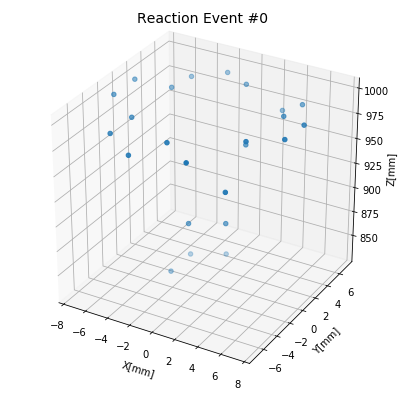

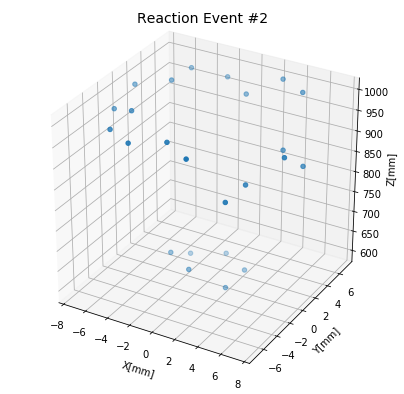

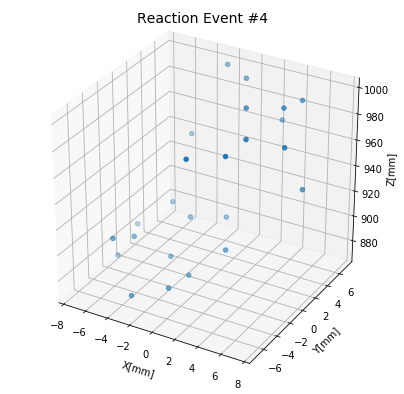

In [6]:
# 3D plot of some Reaction events
print("Reaction Events")
for i in [0,2,4]:
    plot_3d_event(DataList,Labels,i)

Beam Events


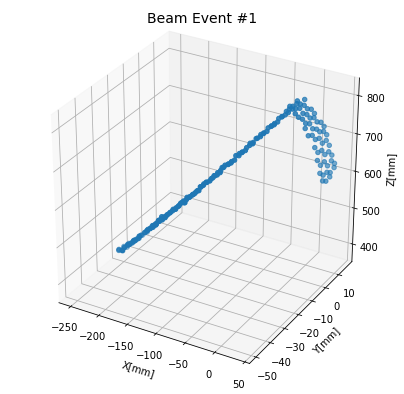

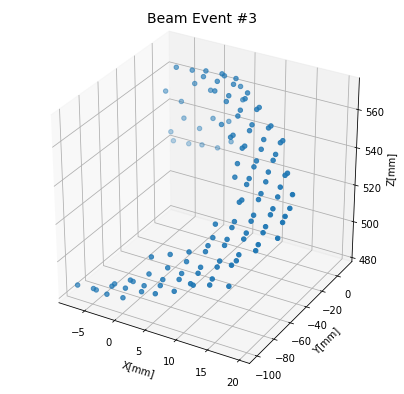

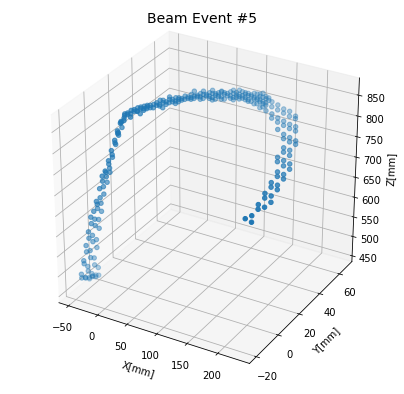

In [7]:
print("Beam Events")    
# 3D plot of some Beam events
for i in [1,3,5]:
    plot_3d_event(DataList,Labels,i)

###  Selecting Features
After plotting the data (two previous cells), it is quite clear that the number of pads plays a crucial role, but not only that. By eyes we can somehow differentiatig the events to be labelled as "beam" since they present a more definite (and almost straight?) track.
We thought some relevant characteristics could be the average value of x,y and z, or rather a weighted avereage, based on the charge deposited. Also, the total deposited charge can be an interesting quantity. 

Here a list of the quantity we calculated:
```
# Every quantity refers to each single event

MeanXPerEvent         # Max X value 
MeanYPerEvent         # Max Y value 
MeanZPerEvent         # Max Z value

MeanWeightedXPerEvent # Charge weighted X 
MeanWeightedYPerEvent # Charge weighted Y
MeanWeightedZPerEvent # Charge weighted Z

StDevXPerEvent        # std X 
StDevYPerEvent        # std Y
StDevZPerEvent        # std Z

SumAPerEvent          # Total deposited charge
PadsPerEvent          # Number of hit pads
FracClosePtsPerEvent  # number of pads inside a region of radius 10cm
```


In [8]:
# Computing Features through the function calc_features (helper_functions.py)
(MeanXPerEvent, MeanYPerEvent, MeanZPerEvent, SumAPerEvent, 
PadsPerEvent, MeanWeightedXPerEvent, MeanWeightedYPerEvent, 
StDevXPerEvent, StDevYPerEvent, StDevZPerEvent,FracClosePtsPerEvent) = calc_features(DataList)


### Visualizing some features 
In order to visualize the features extracted, and whether are well suited for our goal, we will show in the plots below the results obtained. Some of the extracted features will be more relevant, such as the number of hit pads, the total charge deoposited, and the mean Z , while others, like mean x or mean y are not so interesting. 

In [9]:
# Some definition before plotting 

# Splitting train_ind into beam and reaction indexes
train_r_idx = [] # List of indexes of "Reaction" training event
train_b_idx = [] # List of indexes of "Beam" training event

for i in train_idx:
    if Labels[i]>0.5:
        train_r_idx.append(i) # Indexes of "Reaction" training data
    else:
        train_b_idx.append(i) # Indexes of "Beam" training data
        
# Converting into numpy array for later use
train_r_idx = np.array(train_r_idx) 
train_b_idx = np.array(train_b_idx)

# Defining colours for histograms and scatter plot
b_color = 'black'
r_color = 'blue'

#Define legend for 2d (scatter)plots
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Beam', markerfacecolor=b_color, markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Reaction', markerfacecolor=r_color, markersize=15)]

Histograms:


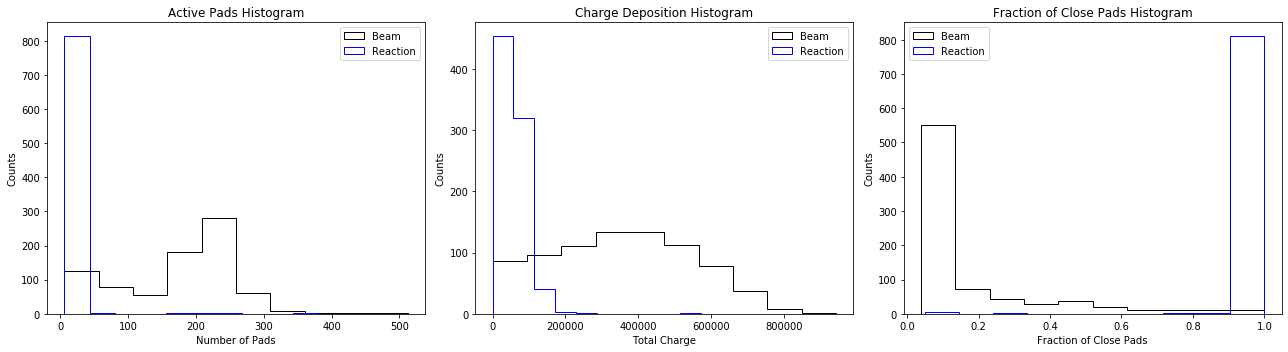

In [10]:
print("Histograms:")
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

#Histograms 
ax[0].hist(PadsPerEvent[train_b_idx], color = b_color, label = 'Beam', histtype = 'step')
ax[0].hist(PadsPerEvent[train_r_idx], color = r_color, label = 'Reaction', histtype = 'step')
ax[0].set_title("Active Pads Histogram")
ax[0].set_xlabel("Number of Pads")
ax[0].set_ylabel("Counts")
ax[0].legend()

ax[1].hist(SumAPerEvent[train_b_idx], color = b_color, label = 'Beam', histtype = 'step')
ax[1].hist(SumAPerEvent[train_r_idx], color = r_color, label = 'Reaction', histtype = 'step')
ax[1].set_title("Charge Deposition Histogram")
ax[1].set_xlabel("Total Charge")
ax[1].set_ylabel("Counts")
ax[1].legend()

ax[2].hist(FracClosePtsPerEvent[train_b_idx], color = b_color, label = 'Beam', histtype = 'step')
ax[2].hist(FracClosePtsPerEvent[train_r_idx], color = r_color, label = 'Reaction', histtype = 'step')
ax[2].set_title("Fraction of Close Pads Histogram")
ax[2].set_xlabel("Fraction of Close Pads")
ax[2].set_ylabel("Counts")
ax[2].legend(loc='upper left')

fig.tight_layout() # adjust automatically spacing between sublots
plt.show()

TO BE COMPLETED
- *Active Pads and Charge Deposition Histogram*, it is clear that the reaction events tend to have a lower amount of active pads, as well a much higher charge deposited. This variables alone can already separate the two type of event quite well. The reason is that beam events comes at high energy, and leave an intense track, while reaction scattering transfer lower energy to its components.
- *Fraction of Close Pads*, this variable represents the fraction of active pads confined in a radius of 10cm, in relation to all the pads fired for that event. It is possible to notice that for the reaction events this variable is close to 1. Beam events have a higher dispension in the three x,y (and z) directions (see also stdev plots).

Scatter Plots: X, Y, Z


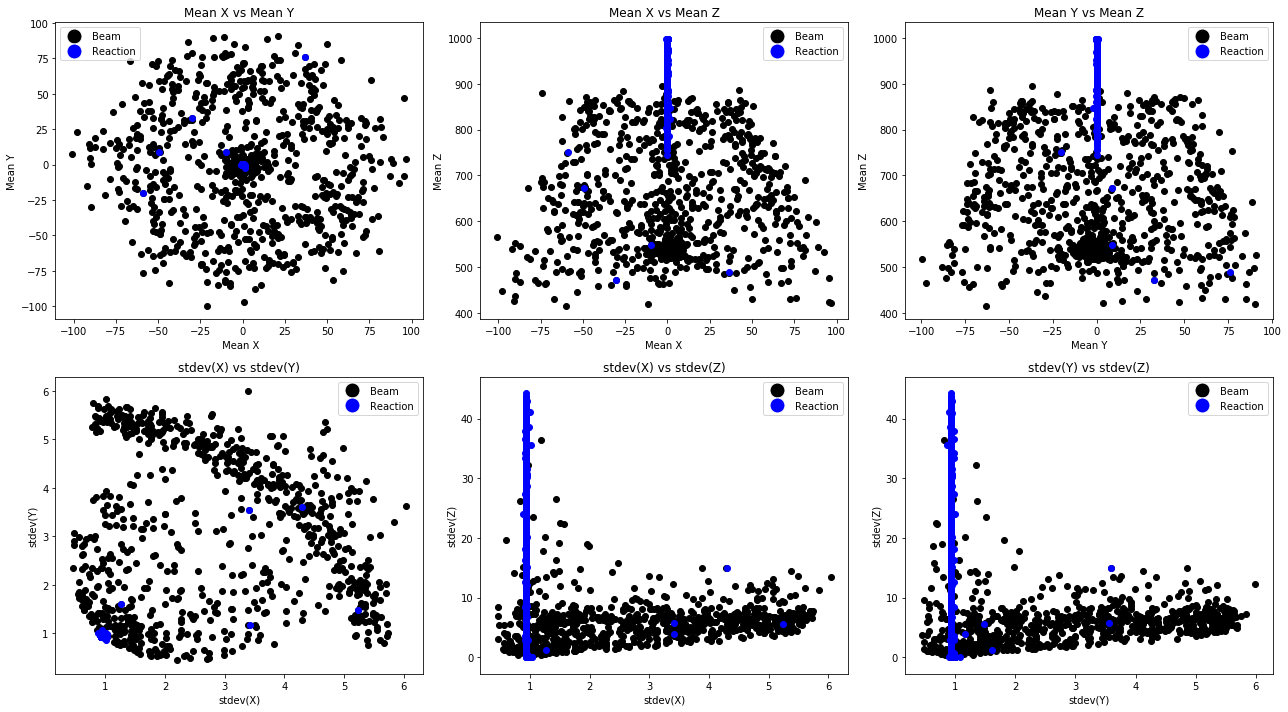

In [11]:
print("Scatter Plots: X, Y, Z")
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# Mean values
ax[0][0].scatter(MeanXPerEvent[train_b_idx],MeanYPerEvent[train_b_idx], c = b_color)
ax[0][0].scatter(MeanXPerEvent[train_r_idx],MeanYPerEvent[train_r_idx], c = r_color)
ax[0][0].set_title("Mean X vs Mean Y")
ax[0][0].set_xlabel(" Mean X")
ax[0][0].set_ylabel("Mean Y")
ax[0][0].legend(handles=legend_elements)

ax[0][1].scatter(MeanXPerEvent[train_b_idx],MeanZPerEvent[train_b_idx], c = b_color)
ax[0][1].scatter(MeanXPerEvent[train_r_idx],MeanZPerEvent[train_r_idx], c = r_color)
ax[0][1].set_title("Mean X vs Mean Z")
ax[0][1].set_xlabel("Mean X")
ax[0][1].set_ylabel("Mean Z")
ax[0][1].legend(handles=legend_elements)

ax[0][2].scatter(MeanYPerEvent[train_b_idx],MeanZPerEvent[train_b_idx], c = b_color)
ax[0][2].scatter(MeanYPerEvent[train_r_idx],MeanZPerEvent[train_r_idx], c = r_color)
ax[0][2].set_title("Mean Y vs Mean Z")
ax[0][2].set_xlabel("Mean Y")
ax[0][2].set_ylabel("Mean Z")
ax[0][2].legend(handles=legend_elements)

# Standard Deviations
ax[1][0].scatter(StDevXPerEvent[train_b_idx],StDevYPerEvent[train_b_idx], c = b_color)
ax[1][0].scatter(StDevXPerEvent[train_r_idx],StDevYPerEvent[train_r_idx], c = r_color)
ax[1][0].set_title("stdev(X) vs stdev(Y)")
ax[1][0].set_xlabel("stdev(X)")
ax[1][0].set_ylabel("stdev(Y)")
ax[1][0].legend(handles=legend_elements)

ax[1][1].scatter(StDevXPerEvent[train_b_idx],StDevZPerEvent[train_b_idx], c = b_color)
ax[1][1].scatter(StDevXPerEvent[train_r_idx],StDevZPerEvent[train_r_idx], c = r_color)
ax[1][1].set_title("stdev(X) vs stdev(Z)")
ax[1][1].set_xlabel("stdev(X)")
ax[1][1].set_ylabel("stdev(Z)")
ax[1][1].legend(handles=legend_elements)

ax[1][2].scatter(StDevYPerEvent[train_b_idx],StDevZPerEvent[train_b_idx], c = b_color)
ax[1][2].scatter(StDevYPerEvent[train_r_idx],StDevZPerEvent[train_r_idx], c = r_color)
ax[1][2].set_title("stdev(Y) vs stdev(Z)")
ax[1][2].set_xlabel("stdev(Y)")
ax[1][2].set_ylabel("stdev(Z)")
ax[1][2].legend(handles=legend_elements)

fig.tight_layout()
plt.show()

TO BE COMPLETED
- *Mean X,Y,Z*, from (X,Y) plot we can notice that reaction evetns tend to lay in the conter of the plot, while beam events are scattered with a certain dispersion. Plots (X,Z) and (Y,Z) are more interesting, since we can notice how rection events have generally an higher mean Z. 
- stdev X,Y,Z, beam events have generally a larger spread in X and Y direction, reaction events the opposite:  higher z dispersion, but much smaller stdev in x and y. 

Scatter Plots: Other Combinations


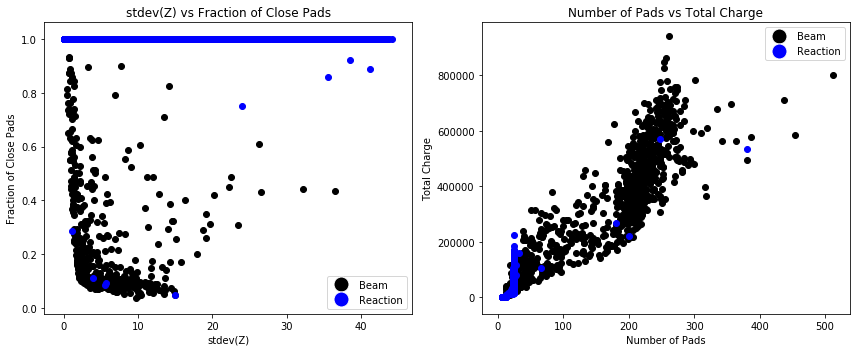

In [12]:
print("Scatter Plots: Other Combinations")
fig, ax = plt.subplots(1,2, figsize=(12, 5))

ax[0].scatter(StDevZPerEvent[train_b_idx],FracClosePtsPerEvent[train_b_idx], c = b_color)
ax[0].scatter(StDevZPerEvent[train_r_idx],FracClosePtsPerEvent[train_r_idx], c = r_color)
ax[0].set_title("stdev(Z) vs Fraction of Close Pads")
ax[0].set_xlabel("stdev(Z)")
ax[0].set_ylabel("Fraction of Close Pads")
ax[0].legend(handles=legend_elements)

ax[1].scatter(PadsPerEvent[train_b_idx],SumAPerEvent[train_b_idx], c = b_color)
ax[1].scatter(PadsPerEvent[train_r_idx],SumAPerEvent[train_r_idx], c = r_color)
ax[1].set_title("Number of Pads vs Total Charge")
ax[1].set_xlabel("Number of Pads")
ax[1].set_ylabel("Total Charge")
ax[1].legend(handles=legend_elements)

fig.tight_layout()
plt.show()

TO BE COMPLETED
- FCP and stdev(z), 
- Total Charge and #pads, Reaction evetns are localized in the region of low amount of active pads, and low charge. Beam event are spread all around the region, with a positive correlation between the two variable.

### Visualizing the outliers
In the plots above there are some outliers: events which label may be mistaken, when looking to the features extracted. We want to plot this events, and see how they look like.

Outliers using different criteria:
stdev(X) > 3 cm       : [ 280  499 1098 1711]
Number of Pads > 100  : [ 280  499 1098 1711]
FCP < 0.4             : [ 280  499 1098 1237 1711]
Outliers that satisfy at least one criterion: [ 280  499 1098 1237 1711]


>>> Outliers:  280
stdev(X)       :  3.41063603285636
Number of Pads :  200.0
FCP            :  9.50%


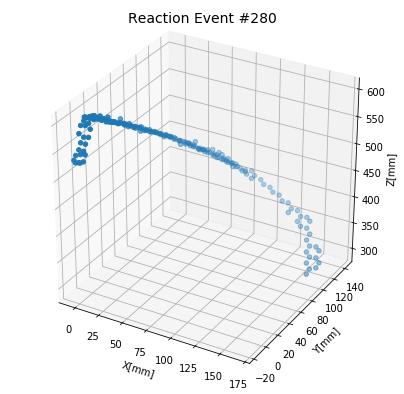

>>> Outliers:  499
stdev(X)       :  4.298400846348025
Number of Pads :  380.0
FCP            :  5.00%


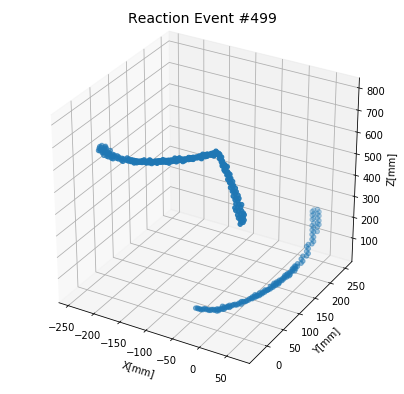

>>> Outliers:  1098
stdev(X)       :  3.4176465527588014
Number of Pads :  180.0
FCP            :  11.11%


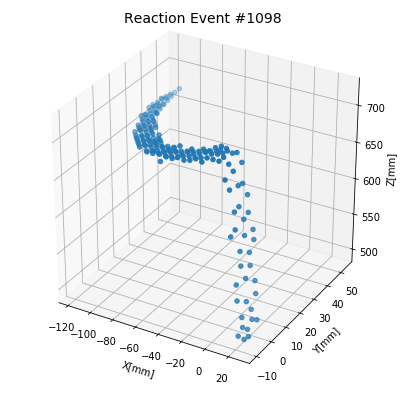

>>> Outliers:  1237
stdev(X)       :  1.258991666148929
Number of Pads :  66.0
FCP            :  28.79%


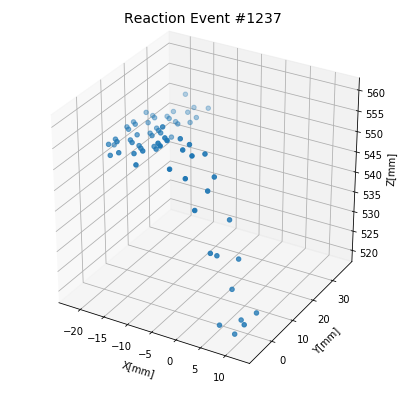

>>> Outliers:  1711
stdev(X)       :  5.235317634930183
Number of Pads :  247.0
FCP            :  8.50%


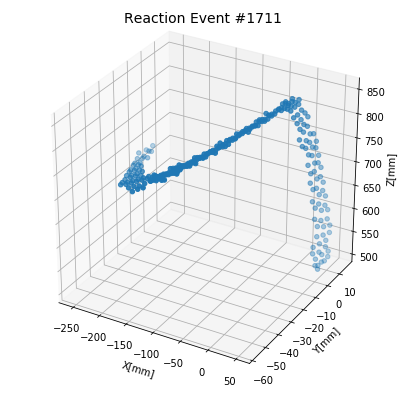

In [13]:
# Outliers Reaction events characteristics
large_x_stdev = train_r_idx[StDevXPerEvent[train_r_idx]>3] # List of reaction events with stdev(X)>3
large_pads = train_r_idx[PadsPerEvent[train_r_idx]>100] # 
small_frac_close = train_r_idx[FracClosePtsPerEvent[train_r_idx]<0.4] # List of reaction event with FCP<0.4 
print("Outliers using different criteria:")
print("stdev(X) > 3 cm       :", np.sort(large_x_stdev))
print("Number of Pads > 100  :", np.sort(large_pads))
print("FCP < 0.4             :", np.sort(small_frac_close))

# Outliers that responde to (at least) one criterion 
outliers = np.union1d(np.union1d(large_x_stdev, large_pads),small_frac_close)
print("Outliers that satisfy at least one criterion:", outliers)
print("\n")

# Plotting Outliers
for i in range(len(outliers)):
    print(">>> Outliers: ", outliers[i])
    print("stdev(X)       : ", StDevXPerEvent[outliers[i]])
    print("Number of Pads : ", PadsPerEvent[outliers[i]])
    print("FCP            :  {:.2f}".format(FracClosePtsPerEvent[outliers[i]]*100) + "%")
    plot_3d_event(DataList,Labels,outliers[i])

# <span style="color:darkred">Design Matrix</span> 


We can see that this features we have extracted are meaningful in order to distinguish beam/reaction, and we gave an interpretation of the graphs obtained. We will keep the most meaninful, and create a design matrix. We call this xSimple, later on we may add other features, making the matrix more omplex, and see if we obtain better results.



In [14]:
xSimple = np.zeros((len(DataList),5)) # Design Matrix with 5 features

# Filling the matrix
for i in range(len(DataList)):
    xSimple[i][0] = MeanZPerEvent[i]
    xSimple[i][1] = StDevXPerEvent[i]
    xSimple[i][2] = FracClosePtsPerEvent[i]
    xSimple[i][3] = SumAPerEvent[i]
    xSimple[i][4] = PadsPerEvent[i]
# not used 
    #xSimple[i][0] = MeanXPerEvent[i]
    #xSimple[i][1] = MeanYPerEvent[i]
    #xSimple[i][1] = StDevYPerEvent[i]
    #xSimple[i][5] = StDevZPerEvent[i]

# Dividing entries in train, val and test
xSimple_train = xSimple[train_idx][:]
xSimple_val = xSimple[val_idx][:]
xSimple_test = xSimple[test_idx][:]
Labels_train = Labels[train_idx]
Labels_val = Labels[val_idx]
Labels_test = Labels[test_idx]

# Converting to DataFrame for better visualization, and for possible later use
X= pd.DataFrame(xSimple)
print("Design Matrix X:")
X.columns = ['Mean Z','stdev(X)','FCP','Total Q','Pads']
X

Design Matrix X:


,Mean Z,stdev(X),FCP,Total Q,Pads
0,961.083333,0.930198,1.000000,41292.864135,24.0
1,661.897436,5.692321,0.097436,322786.822798,195.0
2,877.083333,0.930198,1.000000,89094.206758,24.0
3,529.016129,0.646942,0.153226,168967.813590,124.0
4,938.916667,0.930198,1.000000,34598.337410,24.0
...,...,...,...,...,...
1990,485.930818,3.872534,0.062893,364154.705449,318.0
1991,817.750000,0.930198,1.000000,117215.746684,24.0
1992,526.930233,0.782013,0.418605,37851.885998,43.0
1993,940.083333,0.930198,1.000000,45542.970478,24.0


### Scaling the data 
Scaling (or normalization) of the data
can improve the model performance quite significantly in some cases. Scikit-learn has a few different methods, of which the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) is used below. This scaler transforms each feature to have mean zero and unit variance. 
<a id='StandardScaler'></a>

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(xSimple_train)

# Using the standardscaler
xSimple_train_stdsc = scaler.transform(xSimple_train)
xSimple_val_stdsc = scaler.transform(xSimple_val)

#  <span style="color:darkred">Machine Learning</span> 

After loading the data and selecting the features to use, the actual machine learning can start.
To achieve the best results on the classification task, 
different models will be tested and their performance will be discussed.

##  <span style="color:darkred">Logistic regression</span>

Logistic regression is a widely used method for classification. 
It uses a sigmoid function to calculate the probability for an event to belong to a certain class.
The training procedure is used to optimize the cost function in terms of the parameters $\beta$ of the sigmoid function. In our case the standard implementation of [scikit-learn](https://scikit-learn.org/stable/index.html) is used. Remark that this implementation uses L2 regularization by default. <br>
The print_model_performance funtion is located in the helper functions file. It will be used to print the performance 
characteristics and display the confusion matrix for each model. This is done for both training and validation set separately.


#### <p style="text-align: center;"> The logistic regression: Unscaled data
This time, we will evaluate the model first on unscaled data, and later on the scaled one. We want to show the advantage in using one of the scaling tachniques.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 95.79%
Precision : 92.81%
Recall    : 99.39%
F1-score  : 95.99%
MCC       : 91.81%


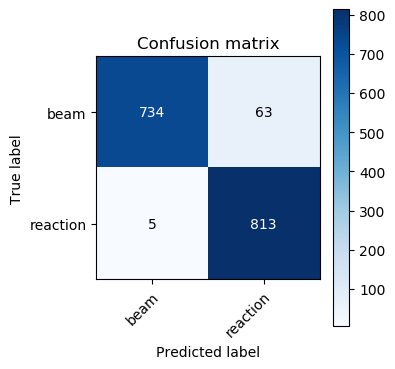


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 96.67%
Precision : 94.57%
Recall    : 98.86%
F1-score  : 96.67%
MCC       : 93.43%


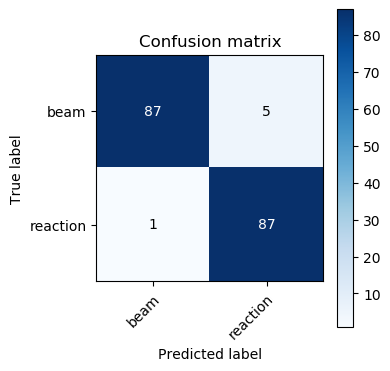

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(xSimple_train, Labels_train) # provide Design matrix and labels

LR0_pred_train = logreg.predict(xSimple_train)
LR0_pred_val = logreg.predict(xSimple_val)

# Function to output model performances
print_model_performance(Labels_train,LR0_pred_train,"Training")
print_model_performance(Labels_val,LR0_pred_val,"Validation")

Not a bad start for our analysis! With an accuracy greater than 95% for both training and validation sets it classifies  quite well. It however seems to classify a significant amount of beam events as reaction events.

#### <p style="text-align: center;"> The logistic regression: Scaled data
Data are now scaled, as showen in [StandardScaler](#StandardScaler) cell

Model performance for training set:
--------------------------------------------------------
Accuracy  : 99.69%
Precision : 100.00%
Recall    : 99.39%
F1-score  : 99.69%
MCC       : 99.38%


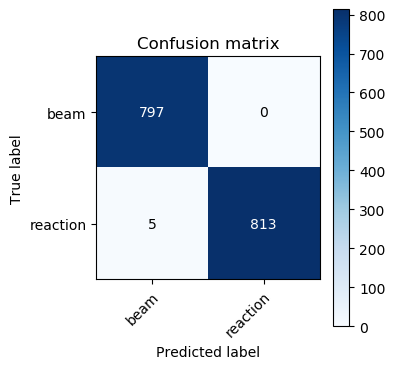


Model performance for validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 100.00%
Recall    : 98.86%
F1-score  : 99.43%
MCC       : 98.89%


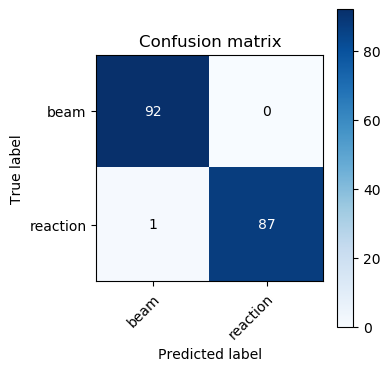

In [17]:
logreg2 = LogisticRegression()
logreg2.fit(xSimple_train_stdsc, Labels_train)

LR_pred_train = logreg2.predict(xSimple_train_stdsc)
LR_pred_val = logreg2.predict(xSimple_val_stdsc)

print_model_performance(Labels_train,LR_pred_train,"training")
print_model_performance(Labels_val,LR_pred_val,"validation")

Comparing to previous results, the improvement is clear. The precision increased to over 99% 
on both training and validation data. This shows it is well worth looking into scaling features of your dataset.
For the remainder of this report all models will be trained using the scaled features.

##  <span style="color:darkred">Random Forest</span>


The random forest method combines the output a number of decision trees to make predictions. Each decision tree 
uses nodes with if-then-else structured conditions on the features that end up in a classification. 
A simple decision tree is displayed below.

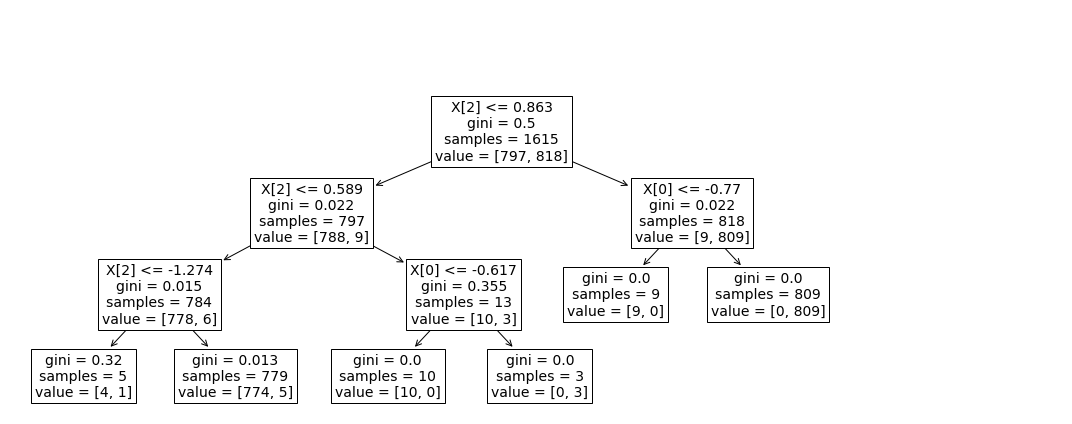

In [18]:
from sklearn import tree
DT = tree.DecisionTreeClassifier(max_depth=3)
DT = DT.fit(xSimple_train_stdsc, Labels_train)

# Better visualization of the tree
fig, ax = plt.subplots(figsize=(15, 6))
tree.plot_tree(DT, fontsize=14)

fig.tight_layout()
plt.show()


To find the best random forest method, a gridsearch is performed with cross-validation on the training set. Both the random forest and the grid search are taken from scikit-learn. The precision is used to determine the optimal model in the grid search.

Grid Search Best Parameters:
 {'bootstrap': True, 'max_features': 2, 'n_estimators': 5}

Grid Search Best Estimetor:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Mean score: 99.39% , Parameters:  {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
Mean score: 99.63% , Parameters:  {'bootstrap': False, 'max_features': 2, 'n_estimators': 4}
Mean score: 99.63% , Parameters:  {'bootstrap': False, 'max_features': 2, 'n_estimators': 5}
Mean score: 99.63% , Parameters:  {'bootstrap': False, 'max_fea

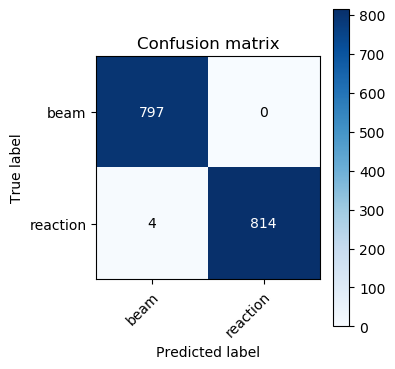


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 100.00%
Recall    : 98.86%
F1-score  : 99.43%
MCC       : 98.89%


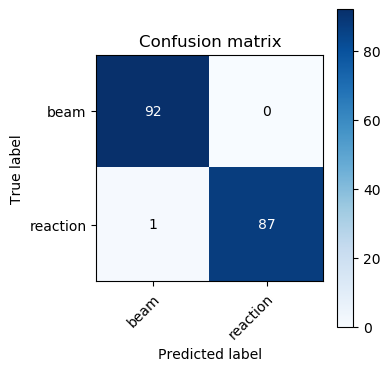

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [ {'n_estimators': [3,4,5,6], 'max_features': [2,3,4,5], 'bootstrap': [False,True]} ]
scoring = 'precision' # 'neg_mean_squared_error', 'accuracy', 'recall'

RFC = RandomForestClassifier()
grid_search_imp = GridSearchCV(RFC, param_grid, cv=5, scoring=scoring)
grid_search_imp.fit(xSimple_train_stdsc, Labels_train)
print("Grid Search Best Parameters:\n", grid_search_imp.best_params_)
print("")
print("Grid Search Best Estimetor:\n",grid_search_imp.best_estimator_)

cvres = grid_search_imp.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("Mean score: {:.2f}".format(mean_score*100) + "% , Parameters: ", params)

feature_importances = grid_search_imp.best_estimator_.feature_importances_
#print(sorted(zip(feature_importances, ["x","y","z","charge","nrofpads"]), reverse=True))

RFC_best = grid_search_imp.best_estimator_
RFC_pred_train = RFC_best.predict(xSimple_train_stdsc)
RFC_pred_val = RFC_best.predict(xSimple_val_stdsc)

# Printing Performances
print_model_performance(Labels_train,RFC_pred_train,"Training")
print_model_performance(Labels_val,RFC_pred_val,"Validation")

The best random forest estimator (found by grid search) reaches an
accuracy of over 99% on both training and validation set. Its results are very similar 
to the ones from the logistic regression. One could suspect the random forest estimator to overfit slightly,given its larger accuracy on the training set and the tendency for random forests to do so, 
but the limited size of the dataset prevents us from proving this. In case it does, one could also restrict the
'max_depth' of the trees to reduce overfitting.


##  <span style="color:darkred">Dense Neural Network</span> 
The next model is a dense neural network (DNN). In this network the features act as input nodes. These are connected to neurons in a hidden layer, which have weights and biases. Based on their activation function and the inputs each neuron calculates an output as input for the next layer. When the output layer is reached the result are compared to the labels. By using backpropagation the weights and biases are updated in order to improve the correspondance of labels and output.

There are quite some parameters that can be tuned for a DNN, including number of hidden layers, number of neurons per layer, type of activation function, using batch normalization or dropout, which optimizer to use,...
No attempt is made to try all combinations. Instead we focused on a restricted number of simple models to select the best one. The one used finally is displayed below in Final Model

In [20]:
# Init the Sequential model
model = tf.keras.Sequential()
# Add Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(xSimple_train_stdsc.shape[1],)))

# Add hidden layer
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))


# Add output layer.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Finally, compile the model and print a summary. Loss function and optimizer is set during compilation.
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,737
Non-trainable params: 128
_________________________________________________________________


The number of epochs and the size of the mini batches for training is set.

In [21]:
# Set parameters for the training run. The full data set is only 2000x5 doubles so large nr of epochs and
# small batch_size will still work well even on cpu
epochs = 20
batch_size = 16

The DNN is fitted on the training set. The performance on the validation set is also shown in the output. It should not take long to complete.

In [22]:
history = model.fit(
    x=xSimple_train_stdsc,
    y=Labels_train,
    validation_data=(xSimple_val_stdsc, Labels_val),
    epochs=epochs,
    batch_size=batch_size,
)

Train on 1615 samples, validate on 180 samples
Epoch 1/20
1615/1615 [==============================] - 2s 968us/sample - loss: 0.1309 - acc: 0.9529 - val_loss: 0.1517 - val_acc: 0.9944
Epoch 2/20
1615/1615 [==============================] - 0s 85us/sample - loss: 0.0320 - acc: 0.9957 - val_loss: 0.0636 - val_acc: 0.9944
Epoch 3/20
1615/1615 [==============================] - 0s 89us/sample - loss: 0.0266 - acc: 0.9969 - val_loss: 0.0378 - val_acc: 0.9944
Epoch 4/20
1615/1615 [==============================] - 0s 88us/sample - loss: 0.0232 - acc: 0.9963 - val_loss: 0.0350 - val_acc: 0.9944
Epoch 5/20
1615/1615 [==============================] - 0s 88us/sample - loss: 0.0251 - acc: 0.9963 - val_loss: 0.0388 - val_acc: 0.9944
Epoch 6/20
1615/1615 [==============================] - 0s 93us/sample - loss: 0.0219 - acc: 0.9969 - val_loss: 0.0394 - val_acc: 0.9944
Epoch 7/20
1615/1615 [==============================] - 0s 114us/sample - loss: 0.0194 - acc: 0.9963 - val_loss: 0.0390 - val_acc:

After training the DNN, the predictions are created and the model performance is printed.
In addition the training history of the model is shown.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.69%
Precision : 100.00%
Recall    : 99.39%
F1-score  : 99.69%
MCC       : 99.38%


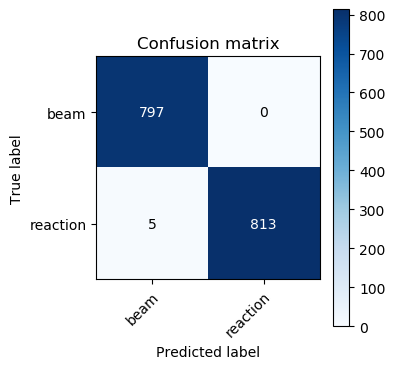


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 100.00%
Recall    : 98.86%
F1-score  : 99.43%
MCC       : 98.89%


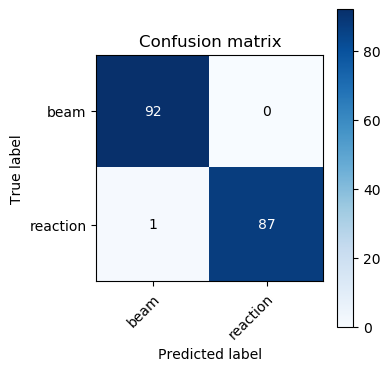

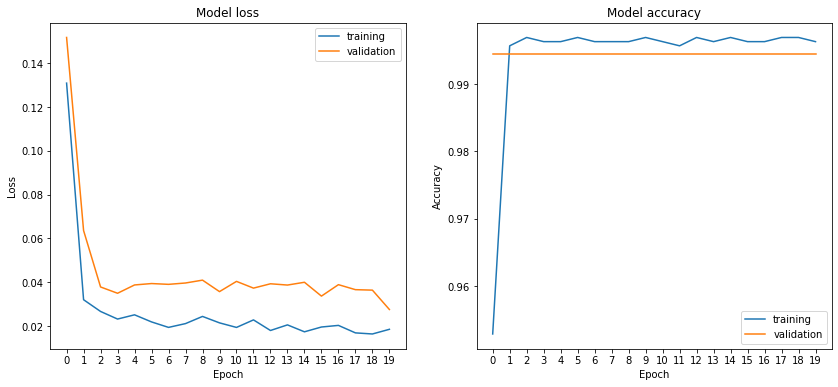

In [23]:
#the predictions contain a number in [0,1] these get mapped to 1 if >0.5 and to 0 if <0.5
#This way  a hard classifier is created
DNN_pred_train_pre = model.predict(xSimple_train_stdsc)
DNN_pred_val_pre = model.predict(xSimple_val_stdsc)
DNN_pred_train = DNN_pred_train_pre > 0.5
DNN_pred_val = DNN_pred_val_pre > 0.5


print_model_performance(Labels_train,DNN_pred_train,"Training")
print_model_performance(Labels_val,DNN_pred_val,"Validation")

make_nn_plots(history)


Also this model performs well, its predictions are consistent with the logistic regression method. 

##  <span style="color:darkred">K-Means</span> 
K-Means (KM) is a method that tries to find and separate clusters in the dataset.
One main difference to the other methods used in this report is that KM is an unsupervised learning method (it does not use the labels). Nevertheless, one can still try to assign each KM-cluster to a class and see what the results are.

#### Elbow method for K-Means
One parameter KM requires is the number of clusters to search for. An obvious choice would be to take the number of clusters equal to the number of classes in the dataset (two). However there exists a way to look for the optimal number of clusters called the elbow method. The KM method tries to minimize the 'inertia', which is the sum of squared error inside a cluster. It is however so that we cannot look for the minima of this in function of the number of clusters, as more clusters always reduce the inertia. Therefore one looks for the 'elbow' of this plot, the number of clusters at which the inertia is lowered significantly, which results in a kink in the curve (which resembles an elbow).

This approach is based on [Geron's notebook](https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb)
        (search for 'finding the optimal number of clusters')

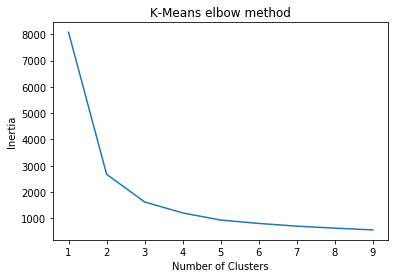

In [30]:
from sklearn.cluster import KMeans
nr_clusters = range(1,10)
inertia = []

for k in nr_clusters:
    km = KMeans(n_clusters=k)
    km.fit(xSimple_train_stdsc)
    inertia.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia') #sum of squared error
plt.title('K-Means elbow method')
plt.plot(nr_clusters,inertia)
fig.tight_layout()
plt.show()

From the figure above it seems there are 
two suitable candidates for the optimal number of clusters k $\in$ [2,3].

Fitting KM for these two cases is straightforward, however the cluster predictions still need to be mapped to class predictions. This means assigning a KM cluster to either beam or reaction events. KM itself does not tell us how to 
map these, so the best mapping is defined as the one that gives the highest accuracy. To do so, the accuracies are
determined for all possible mappings, excluding the trivial ones that map all clusters to the same class.

#### 2-cluster K-Means
In the k=2 case this is quite straightforward, with only two useful mappings.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 91.02%
Precision : 85.24%
Recall    : 99.51%
F1-score  : 91.82%
MCC       : 83.21%


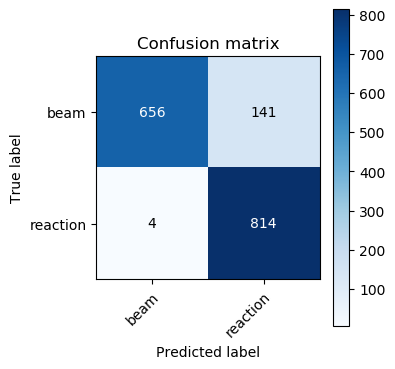


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 91.67%
Precision : 86.14%
Recall    : 98.86%
F1-score  : 92.06%
MCC       : 84.26%


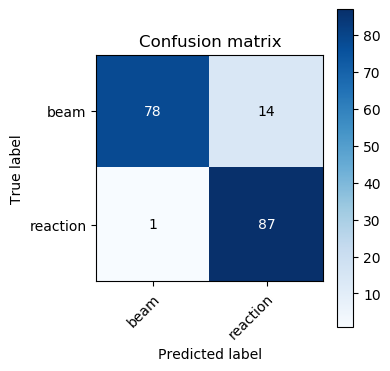

In [31]:
clust = KMeans(n_clusters=2).fit(xSimple_train_stdsc)

KM_pred_train = clust.predict(xSimple_train_stdsc)
KM_pred_val = clust.predict(xSimple_val_stdsc)

#Now we need to find out which cluster is which type of event
#We select the one that gives best accuracy on training set

accuracy_train_norm = accuracy_score(Labels_train, KM_pred_train)
accuracy_train_swap = accuracy_score(Labels_train, 1-KM_pred_train)

if(accuracy_train_swap>accuracy_train_norm):
    KM_pred_train = 1- KM_pred_train
    KM_pred_val = 1 - KM_pred_val

print_model_performance(Labels_train,KM_pred_train,"Training")
print_model_performance(Labels_val,KM_pred_val,"Validation")

#### 3-cluster K-Means
In the k=3 case it involves listing all the possibilities. For brevity of the report, 
the determination of the best mapping has been moved to the helper functions.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.63%
Precision : 99.88%
Recall    : 99.39%
F1-score  : 99.63%
MCC       : 99.26%


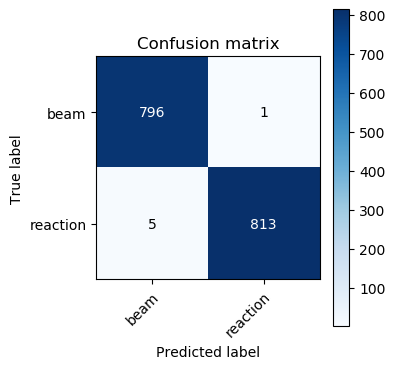


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 100.00%
Recall    : 98.86%
F1-score  : 99.43%
MCC       : 98.89%


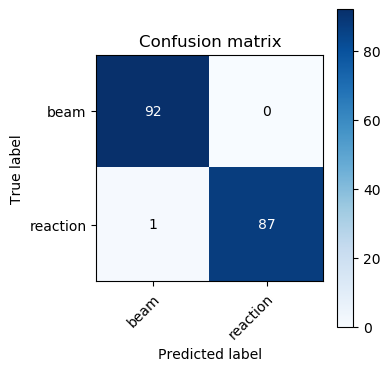

In [32]:
clust3 = KMeans(n_clusters=3).fit(xSimple_train_stdsc)

KM3_pred_train, KM3_pred_val = best_3cl_km(clust3, xSimple_train_stdsc, xSimple_val_stdsc, Labels_train)

print_model_performance(Labels_train,KM3_pred_train,"Training")
print_model_performance(Labels_val,KM3_pred_val,"Validation")

# Conclusions